In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import json
d = json.load('/Users/emamerca/dev/shocks/data/featurized/features__KO__2021-11-01_2022-01-01__30s__2_std.json')

d["features"]
shocks = [el for el in d["features"] if el["direction"] != 0]
non_shocks = [el for el in d["features"] if el["direction"] == 0]
data = shocks + non_shocks

binary = True
if binary:
    for el in data:
         direction = el['direction']
         el['direction'] = 1 if direction == -1 else direction

df = pd.DataFrame.from_dict(data).dropna()
cols = [col for col in df.columns if col != 'direction']
labels = df['direction'].tolist()
X_train, X_test, y_train, y_test = train_test_split(df[cols], labels, test_size=0.3, random_state=42, stratify=labels)


ModuleNotFoundError: No module named 'pandas'

In [ ]:
class_weights = {
   #-1: (len([el for el in labels if el == -1]) / len(labels)),
    0: (len([el for el in labels if el == 0]) / len(labels)),
    1: (len([el for el in labels if el == 1]) / len(labels)),
}

model = RandomForestClassifier(class_weight=class_weights)
model.fit(X_train, y_train)
preds = model.predict(X_test)
print(classification_report(y_test, preds, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     11193
           1       0.82      0.04      0.08       223

    accuracy                           0.98     11416
   macro avg       0.90      0.52      0.53     11416
weighted avg       0.98      0.98      0.97     11416



In [33]:
from sklearn.dummy import DummyClassifier

model = DummyClassifier(strategy="stratified")
model.fit(X_train, y_train)
preds = model.predict(X_test)
print(classification_report(y_test, preds, target_names=['0', '1']))
print(model.class_prior_)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     11193
           1       0.01      0.01      0.01       223

    accuracy                           0.96     11416
   macro avg       0.49      0.49      0.49     11416
weighted avg       0.96      0.96      0.96     11416

[0.98044074 0.01955926]


In [34]:
with open('/home/ema/dev/shocks/data/processed/AVAXBTC_5m.pkl', 'rb') as f:
    d = pickle.load(f)

d["features"]
shocks = [el for el in d["features"] if el["direction"] != 0]
non_shocks = [el for el in d["features"] if el["direction"] == 0]
data = shocks + non_shocks

binary = False
if binary:
    for el in data:
         direction = el['direction']
         el['direction'] = 1 if direction == -1 else direction

df = pd.DataFrame.from_dict(data).dropna()
cols = [col for col in df.columns if col != 'direction']
labels = df['direction'].tolist()
X_train, X_test, y_train, y_test = train_test_split(df[cols], labels, test_size=0.3, random_state=42, stratify=labels)


In [18]:
class_weights = {
   -1: (len([el for el in labels if el == -1]) / len(labels)),
    0: (len([el for el in labels if el == 0]) / len(labels)),
    1: (len([el for el in labels if el == 1]) / len(labels)),
}

model = RandomForestClassifier(class_weight=class_weights)
model.fit(X_train, y_train)
preds = model.predict(X_test)
print(classification_report(y_test, preds, target_names=['-1', '0', '1']))
print(model.class_prior_)

              precision    recall  f1-score   support

          -1       0.50      0.01      0.02        92
           0       0.98      1.00      0.99     11193
           1       0.67      0.02      0.03       131

    accuracy                           0.98     11416
   macro avg       0.72      0.34      0.35     11416
weighted avg       0.97      0.98      0.97     11416



In [35]:
from sklearn.dummy import DummyClassifier

model = DummyClassifier(strategy="stratified")
model.fit(X_train, y_train)
preds = model.predict(X_test)
print(classification_report(y_test, preds, target_names=['-1', '0', '1']))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        92
           0       0.98      0.98      0.98     11193
           1       0.02      0.02      0.02       131

    accuracy                           0.96     11416
   macro avg       0.33      0.33      0.33     11416
weighted avg       0.96      0.96      0.96     11416



array([0.00803394, 0.98044074, 0.01152532])

In [23]:
100 * len(shocks) / len(d["data"])

0.6802120920712502

In [2]:
with open('/home/ema/dev/shocks/data/processed/ATOMUSDT_5m.pkl', 'rb') as f:
    d = pickle.load(f)

d["features"]
shocks = [el for el in d["features"] if el["direction"] != 0]
non_shocks = [el for el in d["features"] if el["direction"] == 0]
data = shocks + non_shocks

binary = True
if binary:
    for el in data:
         direction = el['direction']
         el['direction'] = 1 if direction == -1 else direction

df = pd.DataFrame.from_dict(data).dropna()
cols = [col for col in df.columns if col != 'direction']
labels = df['direction'].tolist()
X_train, X_test, y_train, y_test = train_test_split(df[cols], labels, test_size=0.3, random_state=42, stratify=labels)


In [3]:
len(shocks), len(non_shocks)

(690, 34600)

In [4]:
class_weights = {
    0: (len([el for el in labels if el == 0]) / len(labels)),
    1: (len([el for el in labels if el == 1]) / len(labels)),
}

model = RandomForestClassifier(class_weight=class_weights)
model.fit(X_train, y_train)
preds = model.predict(X_test)
print(classification_report(y_test, preds, target_names=['0', '1']))


              precision    recall  f1-score   support

           0       0.98      1.00      0.99     10094
           1       0.86      0.03      0.06       199

    accuracy                           0.98     10293
   macro avg       0.92      0.52      0.52     10293
weighted avg       0.98      0.98      0.97     10293



In [5]:
from sklearn.dummy import DummyClassifier

model = DummyClassifier(strategy="stratified")
model.fit(X_train, y_train)
preds = model.predict(X_test)
print(classification_report(y_test, preds, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     10094
           1       0.01      0.01      0.01       199

    accuracy                           0.96     10293
   macro avg       0.50      0.49      0.50     10293
weighted avg       0.96      0.96      0.96     10293



In [6]:
start = "2021-05-10 14:05:00"
end = '2021-05-13 11:05:00'
data = d["data"].loc[start : end].copy()



idxs = [el for el in X_test.index if el < len(data)]
shocks_df = data.iloc[[el for el in X_test.index if el < len(data)]]
shocks_in_slice = []
for el in d["shocks"]:
    if el["start"] in shocks_df.index:
        shocks_in_slice.append(el["start"])

In [7]:

idx_to_ts = dict(zip(idxs, shocks_df.index))


In [8]:
features = []
for i, feature in enumerate([el for el in d["features"] if el["direction"] != 0]):
    if i in idxs:
        features.append(feature)

df = pd.DataFrame.from_dict(features).dropna()
labels = df['direction'].tolist()
del df["direction"]
cols = [col for col in df.columns if col != 'direction']

detected_shocks = []
for idx, pred in enumerate(model.predict(df)):
    if pred == 1:
        detected_shocks.append(idx_to_ts[idx])

KeyError: 168

In [10]:
data

,close,volume,returns,log_returns,alpha,beta,sigma,mu_0,mu_1
open time,,,,,,,,,
2021-05-10 14:05:00,27.314,33146.997,0.000146,0.000146,1.842694,0.384134,0.003017,-0.000301,-0.000009
2021-05-10 14:10:00,27.581,10530.876,0.009775,0.009728,1.832710,0.352884,0.003017,-0.000270,0.000017
2021-05-10 14:15:00,27.534,11802.763,-0.001704,-0.001706,1.832710,0.352884,0.003017,-0.000270,0.000017
2021-05-10 14:20:00,27.218,11806.427,-0.011477,-0.011543,1.843186,0.223248,0.003065,-0.000226,-0.000054
2021-05-10 14:25:00,27.171,15589.776,-0.001727,-0.001728,1.843186,0.223248,0.003065,-0.000226,-0.000054
...,...,...,...,...,...,...,...,...,...
2021-05-13 10:45:00,23.042,17692.015,0.001783,0.001781,1.767639,-0.275214,0.005242,-0.000824,-0.001375
2021-05-13 10:50:00,22.734,23197.967,-0.013367,-0.013457,1.798322,-0.317529,0.005323,-0.000831,-0.001385
2021-05-13 10:55:00,22.852,26075.534,0.005190,0.005177,1.804822,-0.341942,0.005341,-0.000809,-0.001387


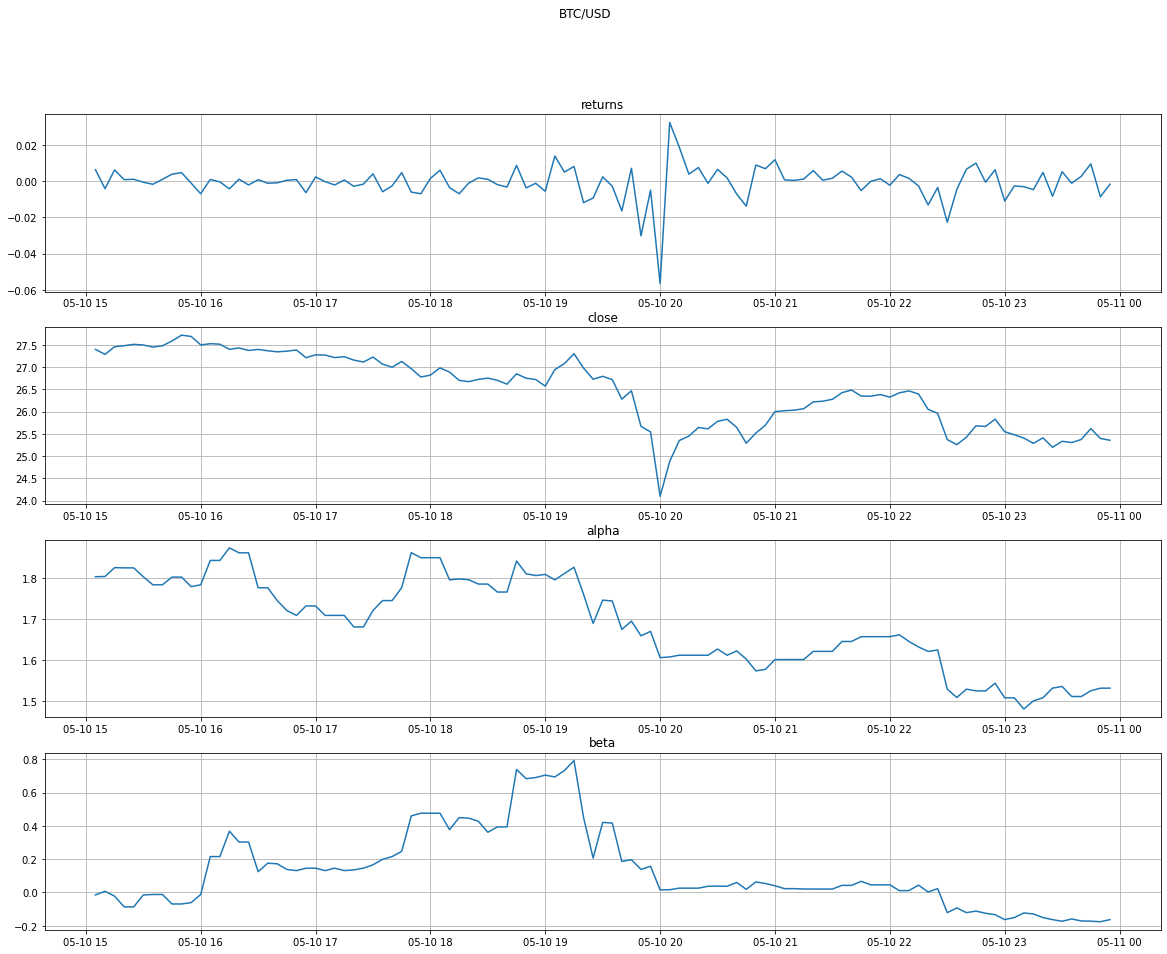

In [13]:
import matplotlib.pyplot as plt

def plot(df, shocks=None):
    fig, axs = plt.subplots(4)
    fig.suptitle('BTC/USD')
    df = df.dropna()
    for idx, key in enumerate("returns close alpha beta".split()):
        axs[idx].plot(df[key])
        axs[idx].set_title(key)
        axs[idx].grid(True)
    
        if shocks is not None:
            #trans = axs.get_xaxis_transform()
            for i, shock in enumerate(shocks[:1]):
                axs[idx].axvline(shock, alpha=0.5, color="red")
                label_position = 0.5 if i%2 == 0 else -0.5
                # plt.text(shock["start"], label_position, shock["duration"])
    plt.savefig("shocks.svg")
    plt.show()

pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams["figure.figsize"] = (20,15)


mask = (data.index > "2021-05-10 15") & (data.index < "2021-05-11")
plot(data.loc[mask]) #shocks_in_slice)